# Time Series Forecasting for NHL Player Performance

This notebook implements time series forecasting models following the TensorFlow tutorial structure to predict player performance (PPG) based on historical season data.

Models implemented:
- Baseline models (last value, repeat)
- Linear model
- Dense (multi-layer) model
- CNN (Convolutional) model
- LSTM (Recurrent) model

In [25]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.1


## Load Data from SQLite Database

In [26]:
# Connect to database
conn = sqlite3.connect('nhl_data copy.db')

# Load skater data with seasons
query = """
SELECT 
    p.player_id,
    p.full_name,
    p.position,
    ss.season_id,
    ss.games_played,
    ss.goals,
    ss.assists,
    ss.marqueur_points,
    ss.marqueur_ppg,
    ss.goals_per_game,
    ss.assists_per_game,
    ss.plus_minus,
    ss.shots,
    ss.powerplay_goals,
    ss.powerplay_points,
    ss.shooting_pct,
    ss.time_on_ice_per_game
FROM players p
JOIN skater_seasons ss ON p.player_id = ss.player_id
WHERE p.role IN ('A', 'D')
ORDER BY p.player_id, ss.season_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(f"Loaded {len(df)} player-season records")
print(f"Unique players: {df['player_id'].nunique()}")
print(f"Unique seasons: {df['season_id'].nunique()}")
df.head()

Loaded 5405 player-season records
Unique players: 1551
Unique seasons: 6


,player_id,full_name,position,season_id,games_played,goals,assists,marqueur_points,marqueur_ppg,goals_per_game,assists_per_game,plus_minus,shots,powerplay_goals,powerplay_points,shooting_pct,time_on_ice_per_game
0,8465009,Zdeno Chara,D,20192020,68,5,9,24.0,0.352941,0.073529,0.132353,26,86,0,0,0.058,1261.0
1,8465009,Zdeno Chara,D,20202021,55,2,8,14.0,0.254545,0.036364,0.145455,5,67,0,0,0.030,1099.0
2,8465009,Zdeno Chara,D,20212022,72,2,12,18.0,0.250000,0.027778,0.166667,8,81,0,0,0.025,1124.0
3,8466138,Joe Thornton,C,20192020,70,7,24,38.0,0.542857,0.100000,0.342857,-19,76,3,8,0.092,930.0
4,8466138,Joe Thornton,C,20202021,44,5,15,25.0,0.568182,0.113636,0.340909,6,42,0,5,0.119,823.0


## Data Preparation

Prepare data by:
1. Filtering players with sufficient history (minimum seasons)
2. Creating normalized features for modeling
3. Splitting into train/validation/test sets

In [27]:
# Filter players with at least minimum seasons
min_seasons = 3
player_season_counts = df.groupby('player_id').size()
valid_players = player_season_counts[player_season_counts >= min_seasons].index

df_filtered = df[df['player_id'].isin(valid_players)].copy()

print(f"Players with at least {min_seasons} seasons: {len(valid_players)}")
print(f"Total player-season records: {len(df_filtered)}")

# Select features for time series modeling
feature_columns = ['marqueur_ppg', 'goals_per_game', 'assists_per_game', 'plus_minus', 
                   'shooting_pct', 'time_on_ice_per_game']

# Target column (we'll predict PPG)
target_column = 'marqueur_ppg'

Players with at least 3 seasons: 962
Total player-season records: 4567


In [28]:
# Create sequences for each player
# Each sequence represents a player's career trajectory

def create_player_sequences(df, player_id, feature_cols):
    """Extract time series sequences for a specific player."""
    player_data = df[df['player_id'] == player_id].sort_values('season_id')
    return player_data[feature_cols].values

# Collect all sequences
all_sequences = []
for player_id in valid_players:
    seq = create_player_sequences(df_filtered, player_id, feature_columns)
    all_sequences.append(seq)

print(f"Created {len(all_sequences)} player sequences")
print(f"Example sequence shape (seasons, features): {all_sequences[0].shape}")

Created 962 player sequences
Example sequence shape (seasons, features): (3, 6)


In [29]:
# Normalize data
# Compute statistics from training data only

# Flatten all sequences to compute global statistics
all_data = np.vstack(all_sequences)

# Split indices for train/val/test (70/15/15)
n = len(all_data)
train_split = int(0.7 * n)
val_split = int(0.85 * n)

train_data = all_data[:train_split]
val_data = all_data[train_split:val_split]
test_data = all_data[val_split:]

# Compute mean and std from training data
train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"\nFeature means: {train_mean}")
print(f"Feature stds: {train_std}")

# Normalize all data
train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# Convert back to DataFrame for easier handling
train_df = pd.DataFrame(train_data, columns=feature_columns)
val_df = pd.DataFrame(val_data, columns=feature_columns)
test_df = pd.DataFrame(test_data, columns=feature_columns)

Training samples: 3196
Validation samples: 685
Test samples: 686

Feature means: [6.11073158e-01 1.58153205e-01 2.71845033e-01 6.08886108e-01
 8.50133601e-02 9.64602003e+02]
Feature stds: [4.40509859e-01 1.45562770e-01 1.96405410e-01 1.23383047e+01
 6.57382647e-02 2.53452650e+02]


In [30]:
train_df.head()

,marqueur_ppg,goals_per_game,assists_per_game,plus_minus,shooting_pct,time_on_ice_per_game
0,-0.585985,-0.581356,-0.710225,2.057909,-0.410923,1.169441
1,-0.809352,-0.836681,-0.643518,0.355893,-0.836854,0.530269
2,-0.819671,-0.895665,-0.535517,0.599038,-0.912914,0.628906
3,-0.154857,-0.399506,0.361559,-1.589269,0.106280,-0.136523
4,-0.097367,-0.305826,0.351640,0.436941,0.516999,-0.558692


## WindowGenerator Class

Following the TensorFlow tutorial, we create a `WindowGenerator` class to handle:
- Splitting sequences into input/label windows
- Creating tf.data.Dataset objects
- Plotting examples

In [31]:
class WindowGenerator:
    """Generates windows from time series data for training and evaluation."""
    
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        """
        Args:
            input_width: Number of time steps for input
            label_width: Number of time steps for labels
            shift: Offset between input and label windows
            train_df, val_df, test_df: DataFrames with normalized data
            label_columns: List of label column names (predict subset of features)
        """
        # Store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """Split a window into inputs and labels."""
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        
        # Slicing doesn't preserve static shape information, so set the shapes
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def make_dataset(self, data):
        """Create tf.data.Dataset from a DataFrame."""
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='marqueur_ppg', max_subplots=3):
        """Plot examples of inputs, labels, and predictions."""
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            
            if n == 0:
                plt.legend()
        
        plt.xlabel('Season offset')
        plt.tight_layout()
        plt.show()

In [32]:
# Create a window generator for single-step predictions
# Predict PPG for next season based on previous 3 seasons

single_step_window = WindowGenerator(
    input_width=3,
    label_width=3,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['marqueur_ppg']
)

print(single_step_window)
print(f"\nInputs shape (batch, time, features): {single_step_window.example[0].shape}")
print(f"Labels shape (batch, time, features): {single_step_window.example[1].shape}")

Total window size: 4
Input indices: [0 1 2]
Label indices: [1 2 3]
Label column name(s): ['marqueur_ppg']

Inputs shape (batch, time, features): (32, 3, 6)
Labels shape (batch, time, features): (32, 3, 1)


In [33]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 3, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None))

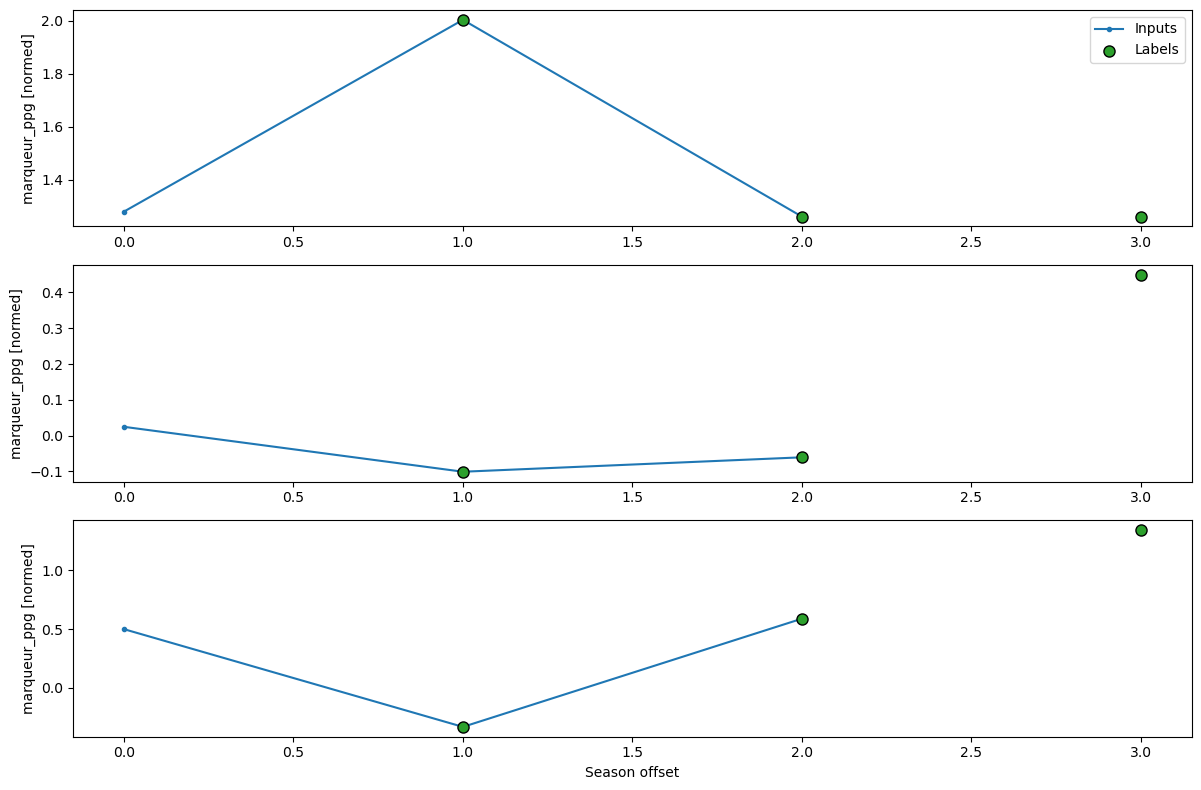

In [34]:
single_step_window.plot()

## Baseline Models

Simple baseline models to compare against.

In [35]:
class Baseline(tf.keras.Model):
    """Baseline model that returns the last value."""
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        print(self.label_index)
        print(inputs)
        print(result)
        return result[:, :, tf.newaxis]

# Create baseline model
baseline = Baseline(label_index=single_step_window.label_indices[0])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
test_performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=0)
test_performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

print(f"Baseline - Val MAE: {val_performance['Baseline'][1]:.4f}")
print(f"Baseline - Test MAE: {test_performance['Baseline'][1]:.4f}")

1
Tensor("data:0", shape=(None, 3, 6), dtype=float32)
Tensor("baseline_9_1/strided_slice:0", shape=(None, 3), dtype=float32)
Baseline - Val MAE: 0.6480
Baseline - Test MAE: 0.6882


1
tf.Tensor(
[[[ 1.28016853e+00  1.40383971e+00  9.07077670e-01  1.12747572e-01
    2.87954658e-01  4.23739880e-01]
  [ 2.00281596e+00  2.39424872e+00  1.05982292e+00  7.61134863e-01
    1.59704006e+00  5.10541081e-01]
  [ 1.26125097e+00  5.84865324e-02  2.01023817e+00  2.13895798e+00
   -2.13168994e-01  1.89146972e+00]]

 [[ 2.46942509e-02  2.63377978e-03  1.68187916e-01 -6.16688132e-01
    6.64751947e-01  6.21015370e-01]
  [-1.00807033e-01 -5.60116097e-02 -2.63657030e-02  3.16991583e-02
    4.18122381e-01  6.48633957e-01]
  [-6.05152734e-02 -1.94301575e-01  2.68985927e-01 -1.75136590e+00
    5.61889470e-01  6.56524956e-01]]

 [[ 4.98731345e-01  9.21626389e-01 -1.30806923e-01 -1.30397663e-01
    5.01787484e-01 -6.32071728e-03]
  [-3.35199147e-01 -2.48703599e-01 -2.66453147e-01  3.16991583e-02
   -4.71770287e-01 -2.78560907e-01]
  [ 5.88083804e-01  1.14398837e+00 -2.60002077e-01  4.36941206e-01
    7.75600612e-01 -2.46996835e-01]]

 [[-4.35219139e-01 -7.54080951e-01  1.19574862e-02 -1.

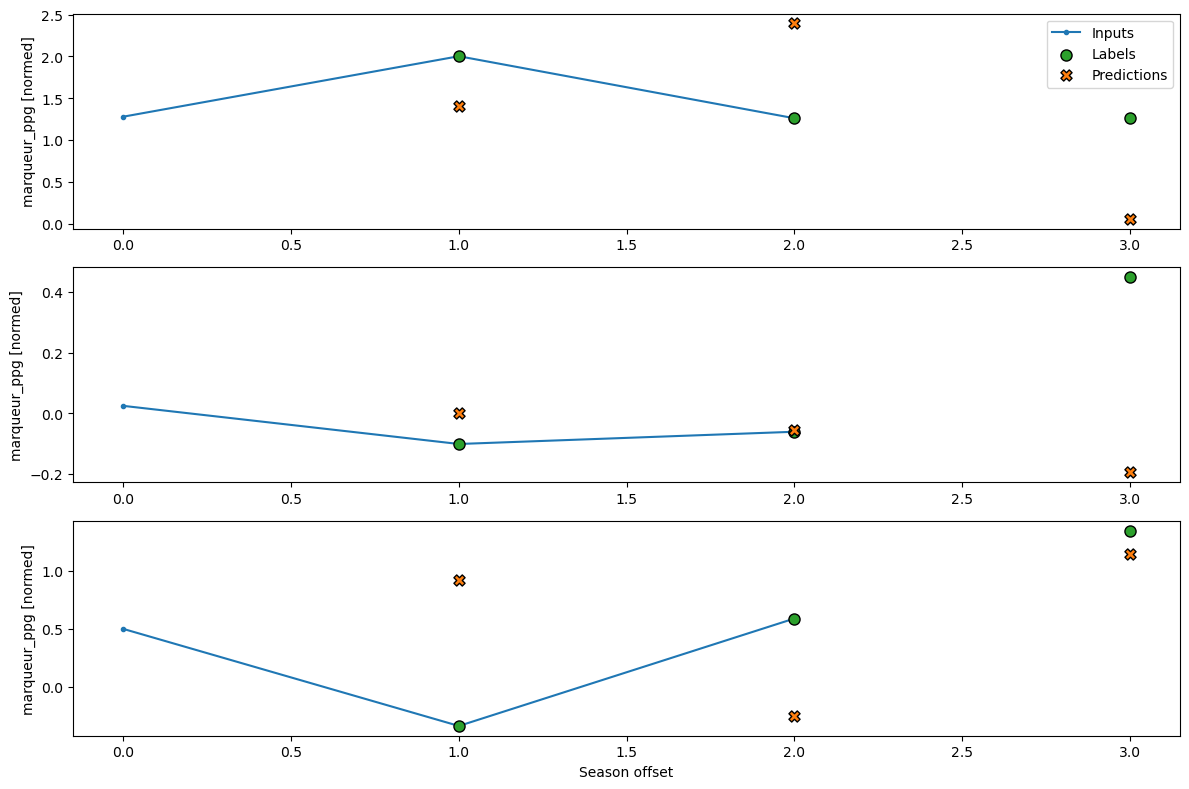

In [36]:
# Visualize baseline predictions
single_step_window.plot(baseline)

## Model 1: Linear Model

A simple linear transformation of the input features.

In [37]:
linear = tf.keras.Sequential([
    layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 3, 6)
Output shape: (32, 3, 1)


In [38]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2, max_epochs=MAX_EPOCHS):
    """Compile and train a model with early stopping."""
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    
    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=0
    )
    return history

In [39]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, verbose=0)
test_performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print(f"Linear - Val MAE: {val_performance['Linear'][1]:.4f}")
print(f"Linear - Test MAE: {test_performance['Linear'][1]:.4f}")

Linear - Val MAE: 0.5410
Linear - Test MAE: 0.5736


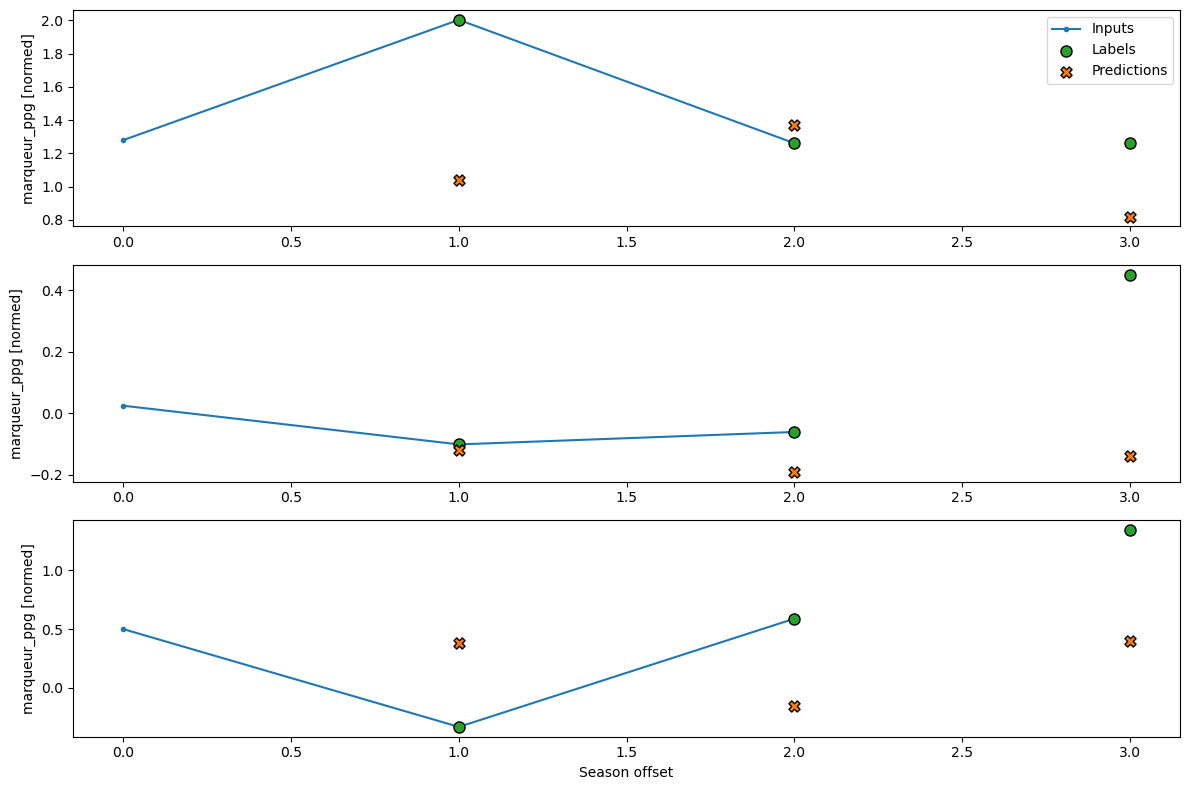

In [40]:
# Visualize linear model predictions
single_step_window.plot(linear)

## Model 2: Dense (Multi-layer) Model

A feedforward neural network with multiple dense layers.

In [41]:
dense = tf.keras.Sequential([
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, verbose=0)
test_performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

print(f"Dense - Val MAE: {val_performance['Dense'][1]:.4f}")
print(f"Dense - Test MAE: {test_performance['Dense'][1]:.4f}")

Dense - Val MAE: 0.5195
Dense - Test MAE: 0.5461


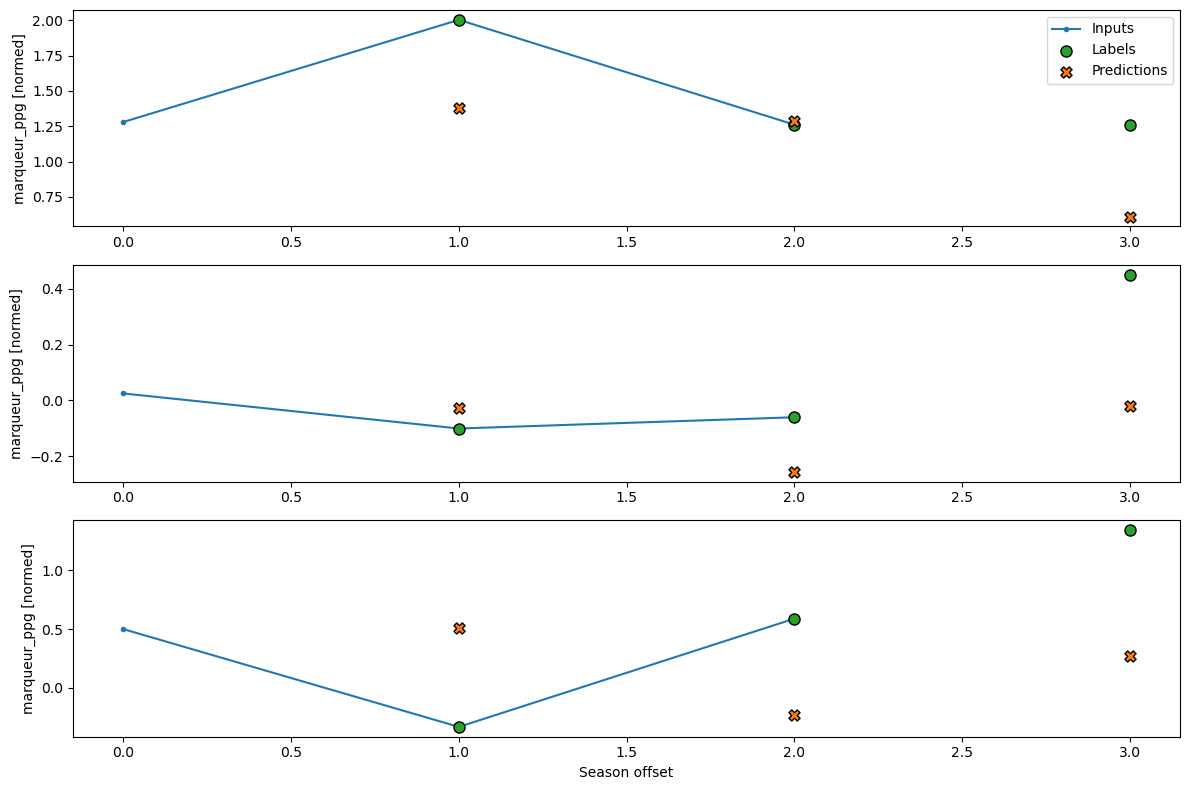

In [42]:
# Visualize dense model predictions
single_step_window.plot(dense)

## Model 3: Multi-step Dense Model

Dense model that outputs predictions for all time steps.

In [43]:
CONV_WIDTH = 3

# Create window that predicts all time steps (not just the last one)
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['marqueur_ppg']
)

print(conv_window)

multi_step_dense = tf.keras.Sequential([
    layers.Lambda(lambda x: x[:, -1:, :]),  # Take the last time step
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1)
])

history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi-step dense'] = multi_step_dense.evaluate(conv_window.val, verbose=0)
test_performance['Multi-step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

print(f"Multi-step Dense - Val MAE: {val_performance['Multi-step dense'][1]:.4f}")
print(f"Multi-step Dense - Test MAE: {test_performance['Multi-step dense'][1]:.4f}")

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['marqueur_ppg']

Multi-step Dense - Val MAE: 0.5232
Multi-step Dense - Test MAE: 0.5531


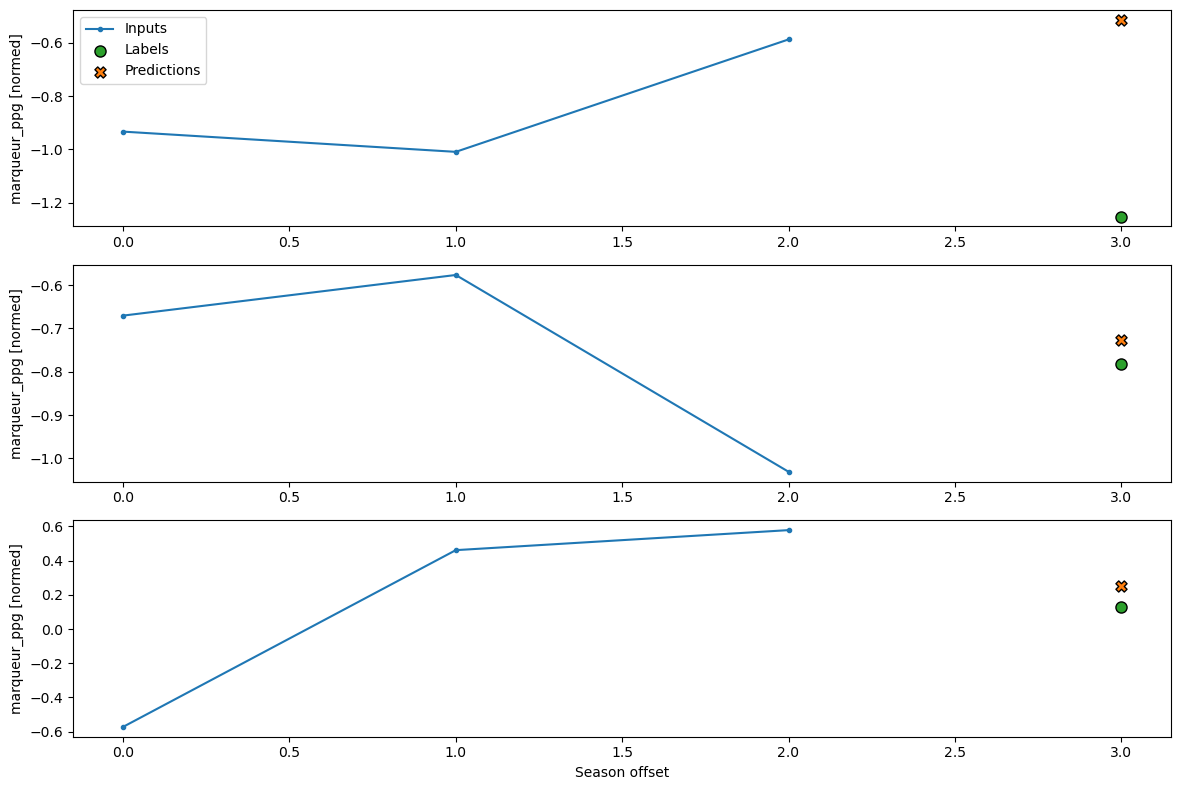

In [44]:
conv_window.plot(multi_step_dense)

## Model 4: Convolutional Neural Network

Uses Conv1D to process the sequence of features.

In [45]:
conv_model = tf.keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1)
])

print('Conv model on `conv_window`')
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val, verbose=0)
test_performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

print(f"Conv - Val MAE: {val_performance['Conv'][1]:.4f}")
print(f"Conv - Test MAE: {test_performance['Conv'][1]:.4f}")

Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)
Conv - Val MAE: 0.5338
Conv - Test MAE: 0.5699


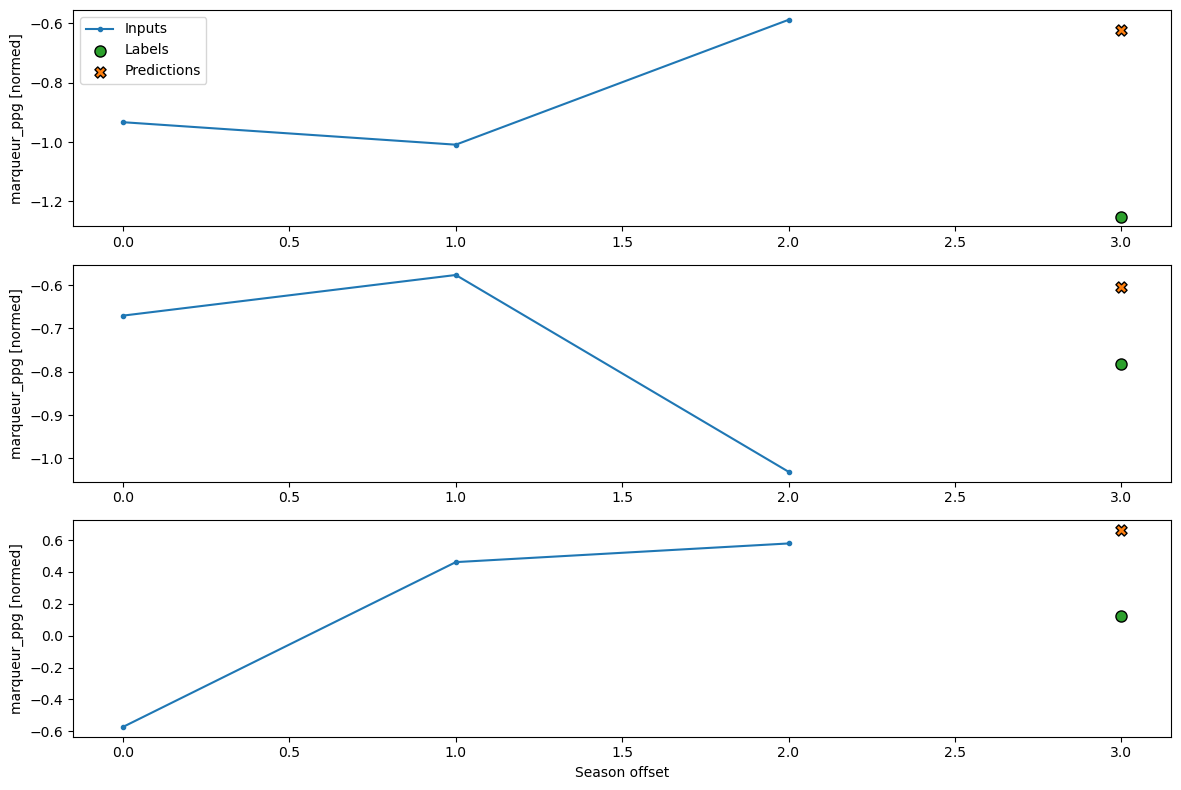

In [46]:
conv_window.plot(conv_model)

## Model 5: LSTM (Recurrent Neural Network)

LSTM processes sequences step-by-step, maintaining internal state.

In [47]:
lstm_model = tf.keras.Sequential([
    layers.LSTM(32, return_sequences=True),
    layers.Dense(units=1)
])

print('LSTM model on `conv_window`')
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_model(conv_window.example[0]).shape)

LSTM model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 3, 1)


In [48]:
history = compile_and_fit(lstm_model, conv_window)

val_performance['LSTM'] = lstm_model.evaluate(conv_window.val, verbose=0)
test_performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

print(f"LSTM - Val MAE: {val_performance['LSTM'][1]:.4f}")
print(f"LSTM - Test MAE: {test_performance['LSTM'][1]:.4f}")

LSTM - Val MAE: 0.6184
LSTM - Test MAE: 0.6234


ValueError: x and y must be the same size

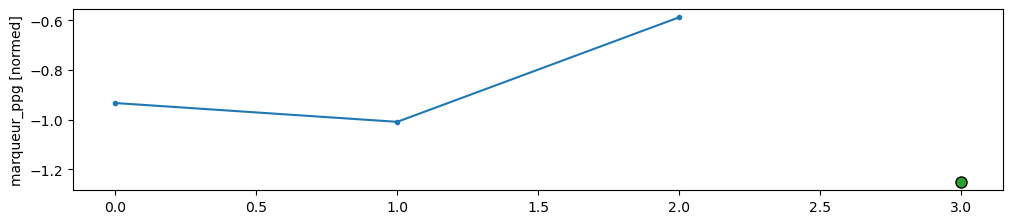

In [49]:
conv_window.plot(lstm_model)

## Performance Comparison

Compare all models on validation and test sets.


=== Model Performance Comparison ===
           Model  Val MAE  Test MAE
           Dense 0.519489  0.546115
Multi-step dense 0.523219  0.553111
            Conv 0.533782  0.569889
          Linear 0.540979  0.573576
            LSTM 0.618422  0.623355
        Baseline 0.648006  0.688233


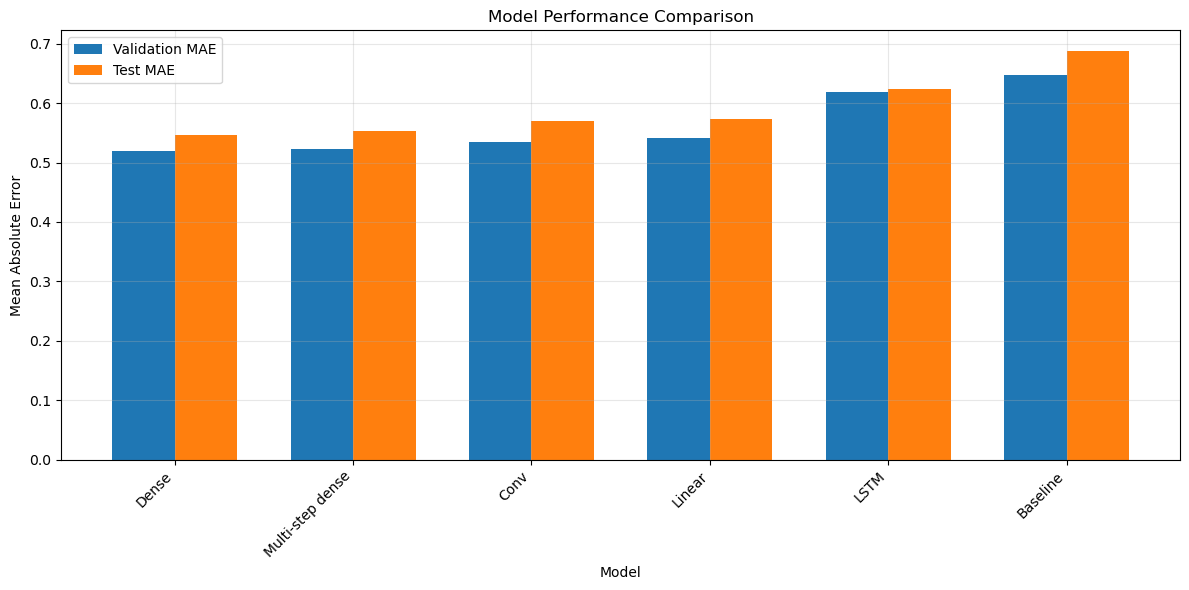

In [50]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(val_performance.keys()),
    'Val MAE': [v[1] for v in val_performance.values()],
    'Test MAE': [v[1] for v in test_performance.values()]
})

comparison_df = comparison_df.sort_values('Val MAE')

print("\n=== Model Performance Comparison ===")
print(comparison_df.to_string(index=False))

# Visualize performance
x = np.arange(len(comparison_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, comparison_df['Val MAE'], width, label='Validation MAE')
ax.bar(x + width/2, comparison_df['Test MAE'], width, label='Test MAE')

ax.set_xlabel('Model')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### Models Implemented:
1. **Baseline** - Returns the last input value (simple persistence model)
2. **Linear** - Single dense layer, linear transformation
3. **Dense** - Multi-layer feedforward neural network
4. **Multi-step Dense** - Dense model with time-step aware predictions
5. **Conv1D** - Convolutional model for sequence processing
6. **LSTM** - Recurrent neural network with memory

### Key Findings:
- All models normalized using training set statistics
- WindowGenerator class handles data windowing and batching
- Early stopping prevents overfitting
- LSTM and Conv1D models can capture temporal patterns

### Next Steps:
1. Tune hyperparameters (hidden units, layers, learning rate)
2. Experiment with different window sizes
3. Add residual connections for deeper models
4. Implement multi-step predictions (forecast multiple seasons)
5. Try autoregressive models for iterative predictions